# 2022-07-15 • Network + VI Noise

## Imports

In [1]:
#

In [2]:
using Revise

In [3]:
using MyToolbox

In [4]:
using VoltoMapSim

[ Info: Precompiling VoltoMapSim [f713100b-c48c-421a-b480-5fcb4c589a9e]


## Params

Based on Roxin; same as previous nb's.

In [5]:
d = 6
p = get_params(
    duration = 10minutes,
    p_conn = 0.04,
    g_EE = 1   / d,
    g_EI = 18  / d,
    g_IE = 36  / d,
    g_II = 31  / d,
    ext_current = Normal(-0.5 * pA/√seconds, 5 * pA/√seconds),
    E_inh = -80 * mV,
    to_record = [1, 801],
);
dumps(p)

ExperimentParams
  sim: NetworkSimParams
    general: GeneralSimParams
      duration: 600
      Δt: 0.0001
      izh_neuron: IzhikevichParams
        C: 1E-10
        k: 7E-07
        v_rest: -0.06
        v_thr: -0.04
        a: 30
        b: -2E-09
        v_peak: 0.035
        v_reset: -0.05
        Δu: 1E-10
        v_t0: -0.06
        u_t0: 0
      synapses: SynapseParams
        E_exc: 0
        E_inh: -0.08
        g_t0: 0
        τ: 0.007
    network: NetworkParams
      N: 1000
      EI_ratio: 4
      p_conn: 0.04
      syn_strengths: LogNormal
        μ: -18.2
        σ: 1
      g_EE: 0.167
      g_EI: 3
      g_IE: 6
      g_II: 5.17
      rngseed: 22022022
      tx_delay: 0.01
      to_record: [1, 801]
    ext_current: Normal
      μ: -5E-13
      σ: 5E-12
    rngseed: 22022022
  imaging: VoltageImagingParams
    spike_SNR: 10
    rngseed: 22022022
  conntest: ConnTestParams
    STA_window_length: 0.1
    num_shuffles: 100
    STA_test_statistic: ptp
    rngseed: 22022022


## Run sim

In [6]:
s = cached(sim, [p.sim]);

In [7]:
s = augment_simdata(s, p);

## Add VI noise; eval conntest perf

In [8]:
SNRs = [Inf, 10, 4, 2, 1];

In [9]:
function get_detection_rates(m; verbose = true)
    detrates = []
    for SNR in SNRs
        q = (@set p.imaging.spike_SNR = SNR)
        vi = add_VI_noise(s.signals[m].v, q)
        ii = get_input_info(m, s, q)
        verbose && @show SNR
        perf = cached(evaluate_conntest_perf, [vi, ii.spiketrains, q], key = [q, m])
        verbose && println(perf.detection_rates, "\n")
        push!(detrates, perf.detection_rates)
    end
    return detrates
end;

## Plot

In [14]:
import PyPlot

In [15]:
using VoltoMapSim.Plot

In [19]:
function plotdetrates(m, title)
    rates = get_detection_rates(m, verbose = false)
    plot_detection_rates(rates, p; title,
        xticklabels = [@sprintf "%.3G" x for x in SNRs],
        xlabel = "Imaging noise (spike-SNR)",
    )
end;

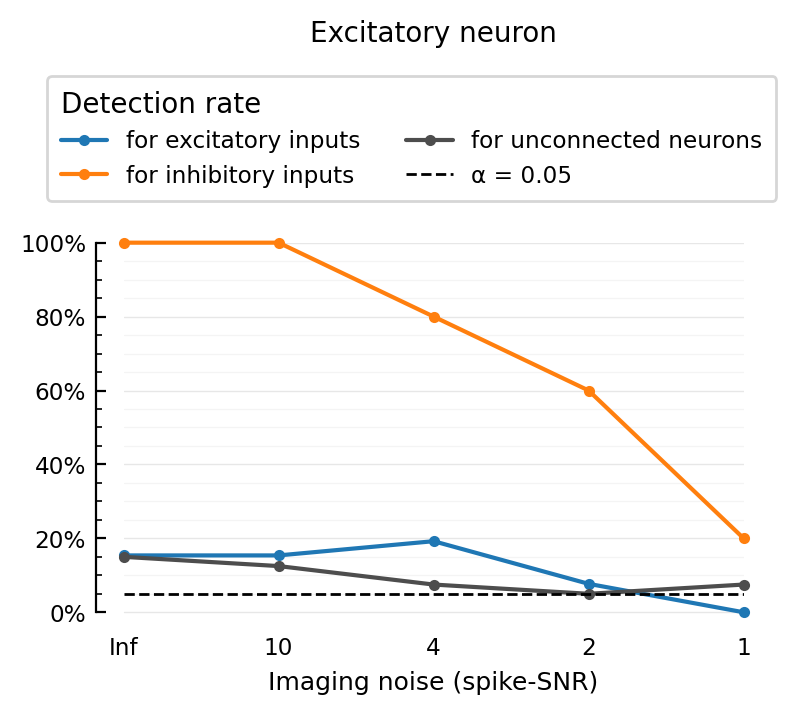

In [38]:
fig, ax = plotdetrates(1, "Excitatory neuron");

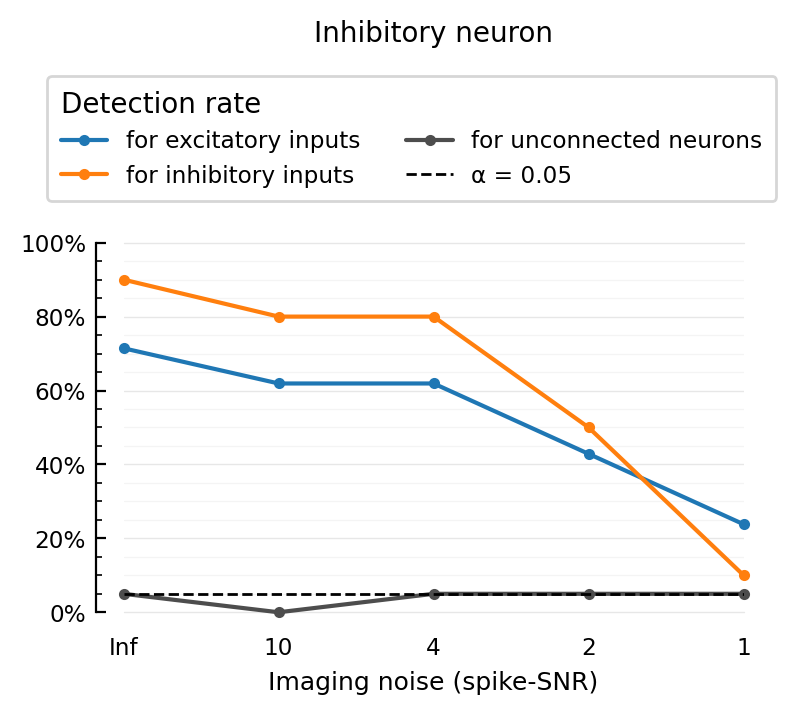

In [37]:
plotdetrates(801, "Inhibitory neuron");